In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Task-2.1:- Image Classification using Resnet network on Cifar 100

Files already downloaded and verified
Files already downloaded and verified

Training ResNet18
Epoch [1/20], Loss: 2.7244, Accuracy: 31.49%, Time: 24.15s, LR: 0.001000
Epoch [2/20], Loss: 1.9340, Accuracy: 47.58%, Time: 24.24s, LR: 0.001000
Epoch [3/20], Loss: 1.5786, Accuracy: 55.86%, Time: 24.23s, LR: 0.001000
Epoch [4/20], Loss: 1.3116, Accuracy: 62.10%, Time: 24.19s, LR: 0.001000
Epoch [5/20], Loss: 1.0877, Accuracy: 68.12%, Time: 24.33s, LR: 0.001000
Epoch [6/20], Loss: 0.9096, Accuracy: 72.57%, Time: 24.26s, LR: 0.001000
Epoch [7/20], Loss: 0.7439, Accuracy: 77.23%, Time: 24.26s, LR: 0.001000
Epoch [8/20], Loss: 0.6183, Accuracy: 80.87%, Time: 24.17s, LR: 0.001000
Epoch [9/20], Loss: 0.5219, Accuracy: 83.69%, Time: 24.21s, LR: 0.001000
Epoch [10/20], Loss: 0.4458, Accuracy: 86.01%, Time: 24.28s, LR: 0.001000
Epoch [11/20], Loss: 0.3719, Accuracy: 88.06%, Time: 24.26s, LR: 0.001000
Epoch [12/20], Loss: 0.3459, Accuracy: 89.01%, Time: 24.43s, LR: 0.001000
Epoch [13/20], Loss: 0.290

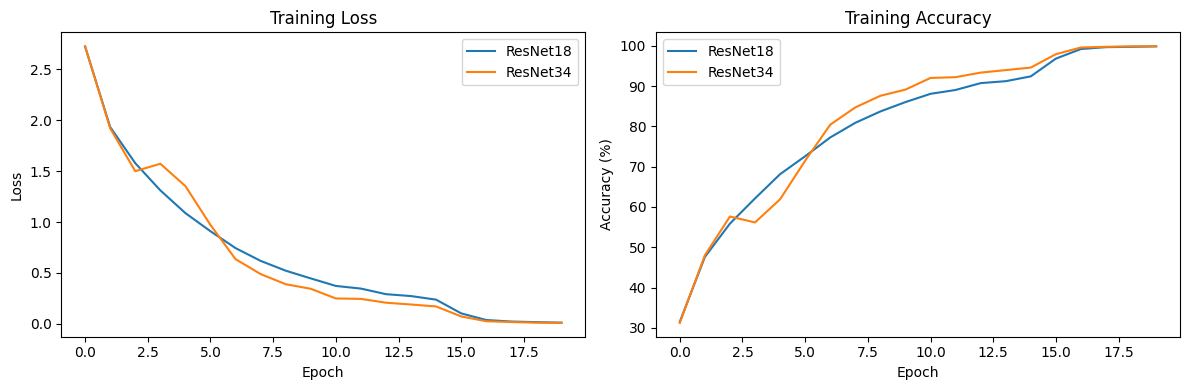

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Step 2: Data Preparation and Loading (No Augmentation)
def load_cifar100_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])
    
    trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    return trainloader, testloader

# Step 3: Model Setup
def initialize_model(model_type='resnet18'):
    if model_type == 'resnet18':
        model = resnet18(pretrained=True)
    elif model_type == 'resnet34':
        model = resnet34(pretrained=True)
    else:
        raise ValueError("Unsupported model type")
    
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 100)
    return model.to(device)

# Step 4: Training Function
def train_model(model, trainloader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        epoch_time = time.time() - start_time
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, '
              f'Accuracy: {epoch_acc:.2f}%, '
              f'Time: {epoch_time:.2f}s, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
    
    return train_losses, train_accuracies

# Step 5: Evaluation Function
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    inference_time = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            inference_time += (time.time() - start_time)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_inference_time = inference_time / len(testloader)
    return accuracy, avg_inference_time

# Step 6: Main Execution and Comparison
def main():
    trainloader, testloader = load_cifar100_data()
    
    models = {
        'ResNet18': initialize_model('resnet18'),
        'ResNet34': initialize_model('resnet34')
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        # Adjusted scheduler: step every 15 epochs instead of 10
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
        
        train_losses, train_accuracies = train_model(
            model, trainloader, criterion, optimizer, scheduler, NUM_EPOCHS)
        
        test_accuracy, inference_time = evaluate_model(model, testloader)
        
        results[model_name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_accuracy': test_accuracy,
            'inference_time': inference_time
        }
    
    print("\nPerformance Comparison:")
    print("-" * 50)
    print(f"{'Model':<10} {'Test Accuracy':<15} {'Avg Inference Time':<20}")
    print("-" * 50)
    for model_name, metrics in results.items():
        print(f"{model_name:<10} {metrics['test_accuracy']:<15.2f} {metrics['inference_time']:<20.4f}")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    for model_name, metrics in results.items():
        plt.plot(metrics['train_losses'], label=model_name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for model_name, metrics in results.items():
        plt.plot(metrics['train_accuracies'], label=model_name)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

Files already downloaded and verified
Files already downloaded and verified

Training ResNet18
Epoch [1/20], Loss: 2.9666, Accuracy: 26.40%, Time: 24.35s
Epoch [2/20], Loss: 2.2652, Accuracy: 40.03%, Time: 24.30s
Epoch [3/20], Loss: 2.0212, Accuracy: 45.37%, Time: 24.46s
Epoch [4/20], Loss: 1.8691, Accuracy: 48.63%, Time: 24.43s
Epoch [5/20], Loss: 1.7452, Accuracy: 51.70%, Time: 24.50s
Epoch [6/20], Loss: 1.6477, Accuracy: 53.95%, Time: 24.46s
Epoch [7/20], Loss: 1.5662, Accuracy: 55.80%, Time: 24.37s
Epoch [8/20], Loss: 1.4779, Accuracy: 58.09%, Time: 24.40s
Epoch [9/20], Loss: 1.4177, Accuracy: 59.44%, Time: 24.50s
Epoch [10/20], Loss: 1.3697, Accuracy: 60.30%, Time: 24.37s
Epoch [11/20], Loss: 1.2959, Accuracy: 62.35%, Time: 24.23s
Epoch [12/20], Loss: 1.2378, Accuracy: 63.83%, Time: 24.27s
Epoch [13/20], Loss: 1.2335, Accuracy: 63.79%, Time: 24.42s
Epoch [14/20], Loss: 1.1483, Accuracy: 66.01%, Time: 24.27s
Epoch [15/20], Loss: 1.1038, Accuracy: 67.18%, Time: 24.22s
Epoch [16/20],

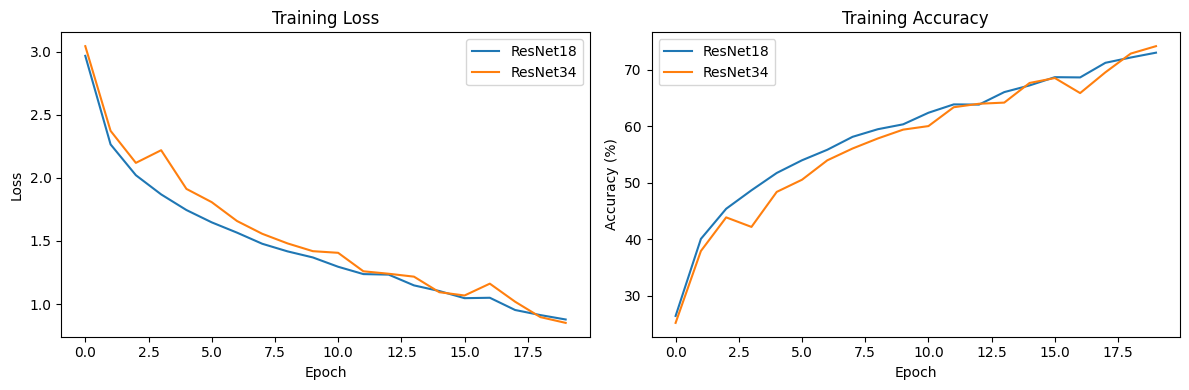

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Step 2: Data Preparation and Loading (With Augmentation)
def load_cifar100_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])
    
    trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    return trainloader, testloader

# Step 3: Model Setup
def initialize_model(model_type='resnet18'):
    if model_type == 'resnet18':
        model = resnet18(pretrained=True)
    elif model_type == 'resnet34':
        model = resnet34(pretrained=True)
    else:
        raise ValueError("Unsupported model type")
    
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 100)
    return model.to(device)

# Step 4: Training Function (No Scheduler)
def train_model(model, trainloader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        epoch_time = time.time() - start_time
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, '
              f'Accuracy: {epoch_acc:.2f}%, '
              f'Time: {epoch_time:.2f}s')
    
    return train_losses, train_accuracies

# Step 5: Evaluation Function
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    inference_time = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            inference_time += (time.time() - start_time)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_inference_time = inference_time / len(testloader)
    return accuracy, avg_inference_time

# Step 6: Main Execution and Comparison
def main():
    trainloader, testloader = load_cifar100_data()
    
    models = {
        'ResNet18': initialize_model('resnet18'),
        'ResNet34': initialize_model('resnet34')
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        train_losses, train_accuracies = train_model(
            model, trainloader, criterion, optimizer, NUM_EPOCHS)
        
        test_accuracy, inference_time = evaluate_model(model, testloader)
        
        results[model_name] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_accuracy': test_accuracy,
            'inference_time': inference_time
        }
    
    print("\nPerformance Comparison:")
    print("-" * 50)
    print(f"{'Model':<10} {'Test Accuracy':<15} {'Avg Inference Time':<20}")
    print("-" * 50)
    for model_name, metrics in results.items():
        print(f"{model_name:<10} {metrics['test_accuracy']:<15.2f} {metrics['inference_time']:<20.4f}")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    for model_name, metrics in results.items():
        plt.plot(metrics['train_losses'], label=model_name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for model_name, metrics in results.items():
        plt.plot(metrics['train_accuracies'], label=model_name)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

# Task-2.2:- Meta learning approaches for image classification on MNIST dataset

       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

<ipython-input-1-141e005173eb>:7: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
<ipython-input-1-141e005173eb>:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


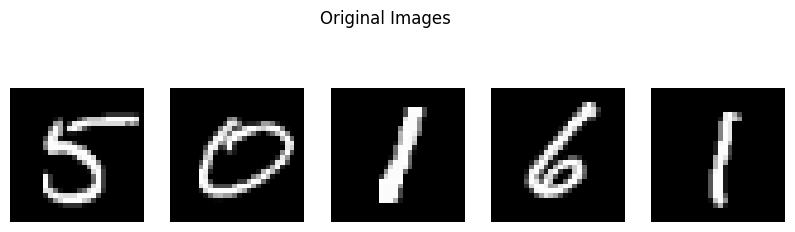

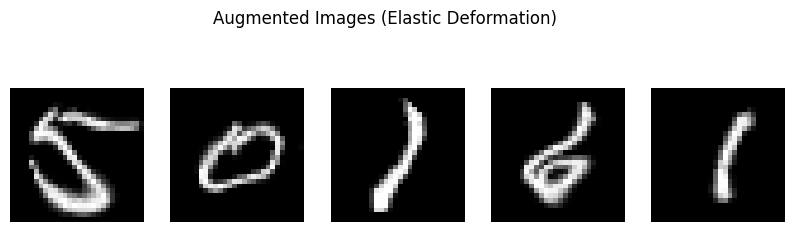

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Split training set into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Elastic Deformation augmentation
def elastic_transform(image, alpha=34, sigma=4, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_."""
    if random_state is None:
        random_state = np.random.RandomState(None)
    
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    
    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    
    distorted_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distorted_image.reshape(shape)

# Apply elastic deformation to a batch of images
def apply_elastic_deformation(images):
    deformed_images = np.zeros_like(images)
    for i in range(images.shape[0]):
        deformed_images[i] = elastic_transform(images[i].squeeze()).reshape(28, 28, 1)
    return deformed_images

# Example of augmented images
sample_images = x_train[:5]
augmented_images = apply_elastic_deformation(sample_images)

plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Original Images')
plt.show()

plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Augmented Images (Elastic Deformation)')
plt.show()

In [2]:
class MNISTMetaDataset:
    def __init__(self, images, labels, num_classes=10):
        self.images = images
        self.labels = labels
        self.num_classes = num_classes
        self.class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    
    def sample_episode(self, n_way, k_shot, q_queries):
        # Select n random classes
        selected_classes = np.random.choice(self.num_classes, n_way, replace=False)
        
        support_set = []
        support_labels = []
        query_set = []
        query_labels = []
        
        for i, class_idx in enumerate(selected_classes):
            # Get all examples for this class
            class_examples = self.class_indices[class_idx]
            
            # Randomly select k_shot + q_queries examples
            selected = np.random.choice(class_examples, k_shot + q_queries, replace=False)
            
            # Add to support and query sets
            support_set.extend(self.images[selected[:k_shot]])
            support_labels.extend([i] * k_shot)
            query_set.extend(self.images[selected[k_shot:]])
            query_labels.extend([i] * q_queries)
        
        # Convert to numpy arrays
        support_set = np.array(support_set)
        support_labels = np.array(support_labels)
        query_set = np.array(query_set)
        query_labels = np.array(query_labels)
        
        # Shuffle support and query sets
        support_shuffle = np.random.permutation(len(support_labels))
        query_shuffle = np.random.permutation(len(query_labels))
        
        return (support_set[support_shuffle], support_labels[support_shuffle]), \
               (query_set[query_shuffle], query_labels[query_shuffle])

# Create meta datasets
train_meta_dataset = MNISTMetaDataset(x_train, y_train)
val_meta_dataset = MNISTMetaDataset(x_val, y_val)
test_meta_dataset = MNISTMetaDataset(x_test, y_test)

# Example episode
(support_set, support_labels), (query_set, query_labels) = train_meta_dataset.sample_episode(
    n_way=5, k_shot=5, q_queries=5)

print("Support set shape:", support_set.shape)
print("Query set shape:", query_set.shape)
print("Support labels:", support_labels)
print("Query labels:", query_labels)

Support set shape: (25, 28, 28, 1)
Query set shape: (25, 28, 28, 1)
Support labels: [0 3 4 0 2 3 0 1 4 2 4 4 3 1 4 0 2 2 1 3 1 1 2 3 0]
Query labels: [2 1 0 3 0 0 4 1 2 4 2 3 1 0 4 3 3 4 2 1 3 4 1 2 0]


In [9]:
class PrototypicalNetwork(tf.keras.Model):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation=None)  # No activation for prototypical networks
        ])
    
    def call(self, inputs):
        return self.encoder(inputs)
    
    # def compute_prototypes(self, support_set, support_labels, n_way):
    #     # Get embeddings for support set
    #     support_embeddings = self(support_set)
        
    #     # Initialize prototypes
    #     prototypes = []
        
    #     # Compute prototype for each class
    #     for class_idx in range(n_way):
    #         # Get embeddings for this class
    #         class_embeddings = tf.gather(support_embeddings, tf.where(tf.equal(support_labels, class_idx))
            
    #         # Compute mean (prototype)
    #         class_prototype = tf.reduce_mean(class_embeddings, axis=0)
    #         prototypes.append(class_prototype)
        
    #     return tf.stack(prototypes)

    def compute_prototypes(self, support_set, support_labels, n_way):
        support_embeddings = self(support_set)
        prototypes = []
        for class_idx in range(n_way):
            class_embeddings = tf.gather(
                support_embeddings, 
                tf.where(tf.equal(support_labels, class_idx))[:, 0]
            )
            class_prototype = tf.reduce_mean(class_embeddings, axis=0)
            prototypes.append(class_prototype)
        return tf.stack(prototypes)

    
    def classify(self, query_set, prototypes):
        # Get embeddings for query set
        query_embeddings = self(query_set)
        
        # Calculate squared Euclidean distances
        distances = tf.reduce_sum(tf.square(query_embeddings[:, tf.newaxis] - prototypes[tf.newaxis, :]), axis=-1)
        
        # Convert distances to probabilities (softmax over -distances)
        probabilities = tf.nn.softmax(-distances)
        
        return probabilities

# Training setup
proto_model = PrototypicalNetwork()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Training loop
def train_prototypical_network(model, dataset, epochs=10, n_way=5, k_shot=5, q_queries=5):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        num_episodes = 100  # Number of episodes per epoch
        
        for episode in range(num_episodes):
            # Sample episode
            (support_set, support_labels), (query_set, query_labels) = dataset.sample_episode(
                n_way, k_shot, q_queries)
            
            with tf.GradientTape() as tape:
                # Compute prototypes
                prototypes = model.compute_prototypes(support_set, support_labels, n_way)
                
                # Classify query set
                predictions = model.classify(query_set, prototypes)
                
                # Compute loss
                loss = loss_fn(query_labels, predictions)
            
            # Compute accuracy
            acc = tf.reduce_mean(
                tf.cast(tf.equal(query_labels, tf.argmax(predictions, axis=1)), tf.float32))
            
            # Update metrics
            epoch_loss += loss
            epoch_acc += acc
            
            # Compute gradients and update weights
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}: Loss = {epoch_loss/num_episodes:.4f}, Accuracy = {epoch_acc/num_episodes:.4f}")

# Train the model
print("Training Prototypical Network:")
train_prototypical_network(proto_model, train_meta_dataset)

# Evaluation function
def evaluate_prototypical_network(model, dataset, num_episodes=100, n_way=5, k_shot=5, q_queries=5):
    total_acc = 0
    
    for episode in range(num_episodes):
        (support_set, support_labels), (query_set, query_labels) = dataset.sample_episode(
            n_way, k_shot, q_queries)
        
        # Compute prototypes
        prototypes = model.compute_prototypes(support_set, support_labels, n_way)
        
        # Classify query set
        predictions = model.classify(query_set, prototypes)
        
        # Compute accuracy
        acc = tf.reduce_mean(
            tf.cast(tf.equal(query_labels, tf.argmax(predictions, axis=1)), tf.float32))
        total_acc += acc
    
    return total_acc / num_episodes

# Evaluate on validation set
val_acc = evaluate_prototypical_network(proto_model, val_meta_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
test_acc = evaluate_prototypical_network(proto_model, test_meta_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Training Prototypical Network:
Epoch 1: Loss = 0.6858, Accuracy = 0.8096
Epoch 2: Loss = 0.2460, Accuracy = 0.9212
Epoch 3: Loss = 0.1596, Accuracy = 0.9504
Epoch 4: Loss = 0.1512, Accuracy = 0.9524
Epoch 5: Loss = 0.1170, Accuracy = 0.9608
Epoch 6: Loss = 0.1167, Accuracy = 0.9596
Epoch 7: Loss = 0.1122, Accuracy = 0.9592
Epoch 8: Loss = 0.0982, Accuracy = 0.9664
Epoch 9: Loss = 0.0915, Accuracy = 0.9688
Epoch 10: Loss = 0.0866, Accuracy = 0.9716
Validation Accuracy: 0.9752
Test Accuracy: 0.9748


In [10]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='sigmoid')  # Using sigmoid for bounded output
        ])
    
    def call(self, inputs):
        return self.encoder(inputs)

# Contrastive loss function
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Training setup
siamese_model = SiameseNetwork()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

# Training loop for Siamese Network
def train_siamese_network(model, dataset, epochs=10, k_shot=5):
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 100  # Number of batches per epoch
        
        for batch in range(num_batches):
            # Sample a batch of pairs
            (support_set, support_labels), _ = dataset.sample_episode(
                n_way=10, k_shot=k_shot, q_queries=0)
            
            # Create pairs and labels
            pairs = []
            labels = []
            
            # Positive pairs (same class)
            for class_idx in range(10):
                class_examples = support_set[support_labels == class_idx]
                if len(class_examples) >= 2:
                    for i in range(len(class_examples)):
                        for j in range(i+1, len(class_examples)):
                            pairs.append((class_examples[i], class_examples[j]))
                            labels.append(1.0)  # Positive pair
            
            # Negative pairs (different classes)
            for i in range(len(support_set)):
                for j in range(i+1, len(support_set)):
                    if support_labels[i] != support_labels[j]:
                        pairs.append((support_set[i], support_set[j]))
                        labels.append(0.0)  # Negative pair
            
            # Convert to numpy arrays
            pairs = np.array(pairs)
            labels = np.array(labels)
            
            # Shuffle pairs
            shuffle_idx = np.random.permutation(len(labels))
            pairs = pairs[shuffle_idx]
            labels = labels[shuffle_idx]
            
            # Limit batch size to prevent memory issues
            batch_size = min(256, len(labels))
            pairs = pairs[:batch_size]
            labels = labels[:batch_size]
            
            with tf.GradientTape() as tape:
                # Get embeddings for both images in pairs
                embeddings1 = model(pairs[:, 0])
                embeddings2 = model(pairs[:, 1])
                
                # Compute Euclidean distance between embeddings
                distances = tf.sqrt(tf.reduce_sum(
                    tf.square(embeddings1 - embeddings2), axis=1))
                
                # Compute contrastive loss
                loss = contrastive_loss(labels, distances)
            
            # Update metrics
            epoch_loss += loss
            
            # Compute gradients and update weights
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}: Loss = {epoch_loss/num_batches:.4f}")

# Train the model
print("Training Siamese Network:")
train_siamese_network(siamese_model, train_meta_dataset)

# Evaluation function for Siamese Network
def evaluate_siamese_network(model, dataset, num_episodes=100, n_way=5, k_shot=5, q_queries=5):
    total_acc = 0
    
    for episode in range(num_episodes):
        (support_set, support_labels), (query_set, query_labels) = dataset.sample_episode(
            n_way, k_shot, q_queries)
        
        # Get embeddings for support and query sets
        support_embeddings = model(support_set)
        query_embeddings = model(query_set)
        
        # Classify each query example by nearest neighbor
        correct = 0
        for i in range(len(query_set)):
            # Compute distances to all support embeddings
            distances = tf.sqrt(tf.reduce_sum(
                tf.square(query_embeddings[i] - support_embeddings), axis=1))
            
            # Predict the class of the nearest neighbor
            predicted_class = support_labels[tf.argmin(distances)]
            
            # Check if prediction is correct
            if predicted_class == query_labels[i]:
                correct += 1
        
        # Compute accuracy for this episode
        total_acc += correct / len(query_set)
    
    return total_acc / num_episodes

# Evaluate on validation set
val_acc = evaluate_siamese_network(siamese_model, val_meta_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
test_acc = evaluate_siamese_network(siamese_model, test_meta_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Training Siamese Network:
Epoch 1: Loss = 0.1991
Epoch 2: Loss = 0.0549
Epoch 3: Loss = 0.0459
Epoch 4: Loss = 0.0395
Epoch 5: Loss = 0.0359
Epoch 6: Loss = 0.0320
Epoch 7: Loss = 0.0293
Epoch 8: Loss = 0.0282
Epoch 9: Loss = 0.0269
Epoch 10: Loss = 0.0260
Validation Accuracy: 0.9692
Test Accuracy: 0.9692


In [11]:
class MatchingNetwork(tf.keras.Model):
    def __init__(self):
        super(MatchingNetwork, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation=None)  # No activation for matching networks
        ])
    
    def call(self, inputs):
        return self.encoder(inputs)
    
    def attention(self, query_embedding, support_embeddings):
        # Compute cosine similarity
        query_norm = tf.nn.l2_normalize(query_embedding, axis=1)
        support_norm = tf.nn.l2_normalize(support_embeddings, axis=1)
        
        # Calculate attention weights
        attention_weights = tf.nn.softmax(
            tf.matmul(query_norm, support_norm, transpose_b=True))
        
        return attention_weights
    
    def classify(self, query_set, support_set, support_labels, n_way):
        # Get embeddings for support and query sets
        support_embeddings = self(support_set)
        query_embeddings = self(query_set)
        
        # Compute attention weights
        attention_weights = self.attention(query_embeddings, support_embeddings)
        
        # Create one-hot encoded labels for support set
        support_labels_onehot = tf.one_hot(support_labels, depth=n_way)
        
        # Compute class probabilities
        probabilities = tf.matmul(attention_weights, support_labels_onehot)
        
        return probabilities

# Training setup
matching_model = MatchingNetwork()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Training loop for Matching Network
def train_matching_network(model, dataset, epochs=10, n_way=5, k_shot=1, q_queries=5):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        num_episodes = 100  # Number of episodes per epoch
        
        for episode in range(num_episodes):
            # Sample episode
            (support_set, support_labels), (query_set, query_labels) = dataset.sample_episode(
                n_way, k_shot, q_queries)
            
            with tf.GradientTape() as tape:
                # Classify query set
                predictions = model.classify(query_set, support_set, support_labels, n_way)
                
                # Convert query labels to one-hot
                query_labels_onehot = tf.one_hot(query_labels, depth=n_way)
                
                # Compute loss
                loss = loss_fn(query_labels_onehot, predictions)
            
            # Compute accuracy
            acc = tf.reduce_mean(
                tf.cast(tf.equal(query_labels, tf.argmax(predictions, axis=1)), tf.float32))
            
            # Update metrics
            epoch_loss += loss
            epoch_acc += acc
            
            # Compute gradients and update weights
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}: Loss = {epoch_loss/num_episodes:.4f}, Accuracy = {epoch_acc/num_episodes:.4f}")

# Train the model (one-shot learning)
print("Training Matching Network (One-Shot Learning):")
train_matching_network(matching_model, train_meta_dataset, k_shot=1)

# Evaluation function for Matching Network
def evaluate_matching_network(model, dataset, num_episodes=100, n_way=5, k_shot=1, q_queries=5):
    total_acc = 0
    
    for episode in range(num_episodes):
        (support_set, support_labels), (query_set, query_labels) = dataset.sample_episode(
            n_way, k_shot, q_queries)
        
        # Classify query set
        predictions = model.classify(query_set, support_set, support_labels, n_way)
        
        # Compute accuracy
        acc = tf.reduce_mean(
            tf.cast(tf.equal(query_labels, tf.argmax(predictions, axis=1)), tf.float32))
        total_acc += acc
    
    return total_acc / num_episodes

# Evaluate on validation set
val_acc = evaluate_matching_network(matching_model, val_meta_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
test_acc = evaluate_matching_network(matching_model, test_meta_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Training Matching Network (One-Shot Learning):
Epoch 1: Loss = 1.2864, Accuracy = 0.6532
Epoch 2: Loss = 1.1380, Accuracy = 0.7660
Epoch 3: Loss = 1.0930, Accuracy = 0.8004
Epoch 4: Loss = 1.0565, Accuracy = 0.8672
Epoch 5: Loss = 1.0427, Accuracy = 0.8752
Epoch 6: Loss = 1.0347, Accuracy = 0.8684
Epoch 7: Loss = 1.0143, Accuracy = 0.9080
Epoch 8: Loss = 1.0108, Accuracy = 0.9008
Epoch 9: Loss = 0.9970, Accuracy = 0.9096
Epoch 10: Loss = 0.9940, Accuracy = 0.9304
Validation Accuracy: 0.9404
Test Accuracy: 0.9460


In [12]:
# We can reuse the Siamese Network from Task 3.2, but evaluate it in one-shot setting

# Evaluation function for Siamese Network in one-shot setting
def evaluate_siamese_one_shot(model, dataset, num_episodes=100, n_way=5, k_shot=1, q_queries=5):
    total_acc = 0
    
    for episode in range(num_episodes):
        (support_set, support_labels), (query_set, query_labels) = dataset.sample_episode(
            n_way, k_shot, q_queries)
        
        # Get embeddings for support and query sets
        support_embeddings = model(support_set)
        query_embeddings = model(query_set)
        
        # Classify each query example by nearest neighbor
        correct = 0
        for i in range(len(query_set)):
            # Compute distances to all support embeddings
            distances = tf.sqrt(tf.reduce_sum(
                tf.square(query_embeddings[i] - support_embeddings), axis=1))
            
            # Predict the class of the nearest neighbor
            predicted_class = support_labels[tf.argmin(distances)]
            
            # Check if prediction is correct
            if predicted_class == query_labels[i]:
                correct += 1
        
        # Compute accuracy for this episode
        total_acc += correct / len(query_set)
    
    return total_acc / num_episodes

# Evaluate on validation set
val_acc = evaluate_siamese_one_shot(siamese_model, val_meta_dataset)
print(f"Siamese Network One-Shot Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
test_acc = evaluate_siamese_one_shot(siamese_model, test_meta_dataset)
print(f"Siamese Network One-Shot Test Accuracy: {test_acc:.4f}")

Siamese Network One-Shot Validation Accuracy: 0.9584
Siamese Network One-Shot Test Accuracy: 0.9648


In [17]:
# Compare all models
def compare_models(dataset, num_episodes=100, n_way=5, k_shot=5, q_queries=5):
    # Prototypical Networks
    proto_acc = evaluate_prototypical_network(
        proto_model, dataset, num_episodes, n_way, k_shot, q_queries)
    
    # Siamese Networks
    siamese_acc = evaluate_siamese_network(
        siamese_model, dataset, num_episodes, n_way, k_shot, q_queries)
    
    # Matching Networks (one-shot)
    matching_acc = evaluate_matching_network(
        matching_model, dataset, num_episodes, n_way, k_shot=1, q_queries=q_queries)
    
    # Siamese Networks (one-shot)
    siamese_one_shot_acc = evaluate_siamese_one_shot(
        siamese_model, dataset, num_episodes, n_way, k_shot=1, q_queries=q_queries)
    
    print("\nModel Comparison:")
    print(f"Prototypical Network ({k_shot}-shot): {proto_acc:.4f}")
    print(f"Siamese Network ({k_shot}-shot): {siamese_acc:.4f}")
    print(f"Matching Network (1-shot): {matching_acc:.4f}")
    print(f"Siamese Network (1-shot): {siamese_one_shot_acc:.4f}")

# Compare on test set
print("Performance on Test Set:")
compare_models(test_meta_dataset)

# # Analyze impact of training data size
# def analyze_data_size_impact(model, dataset, sizes=[100, 500, 1000, 5000, 10000], 
#                            num_episodes=100, n_way=5, k_shot=5, q_queries=5):
#     accuracies = []
    
#     for size in sizes:
#         # Create a subset of the dataset
#         indices = np.random.choice(len(dataset.images), size, replace=False)
#         subset_images = dataset.images[indices]
#         subset_labels = dataset.labels[indices]
        
#         # Create meta dataset
#         subset_meta_dataset = MNISTMetaDataset(subset_images, subset_labels)
        
#         # Evaluate model
#         if isinstance(model, PrototypicalNetwork):
#             acc = evaluate_prototypical_network(
#                 model, subset_meta_dataset, num_episodes, n_way, k_shot, q_queries)
#         elif isinstance(model, MatchingNetwork):
#             acc = evaluate_matching_network(
#                 model, subset_meta_dataset, num_episodes, n_way, k_shot=1, q_queries=q_queries)
#         else:  # Siamese Network
#             acc = evaluate_siamese_network(
#                 model, subset_meta_dataset, num_episodes, n_way, k_shot, q_queries)
        
#         accuracies.append(acc)
#         print(f"Training size: {size}, Accuracy: {acc:.4f}")
    
#     # Plot results
#     plt.figure(figsize=(8, 5))
#     plt.plot(sizes, accuracies, marker='o')
#     plt.xlabel('Training Set Size')
#     plt.ylabel('Accuracy')
#     plt.title('Impact of Training Data Size on Model Performance')
#     plt.grid(True)
#     plt.show()

# # Analyze for Prototypical Network
# print("\nAnalyzing Impact of Training Data Size on Prototypical Network:")
# analyze_data_size_impact(proto_model, train_meta_dataset)

from collections import defaultdict
def sample_episode(self, n_way, k_shot, q_queries):
    selected_classes = random.sample(self.classes, n_way)

    support_set, support_labels = [], []
    query_set, query_labels = [], []

    for i, cls in enumerate(selected_classes):
        class_examples = self.class_to_images[cls]

        # ✅ Check if enough samples exist
        if len(class_examples) < (k_shot + q_queries):
            continue  # skip this class or raise an exception

        selected = np.random.choice(class_examples, k_shot + q_queries, replace=False)
        support_examples = selected[:k_shot]
        query_examples = selected[k_shot:]

        support_set.extend(support_examples)
        support_labels.extend([i] * k_shot)
        query_set.extend(query_examples)
        query_labels.extend([i] * q_queries)

    return (torch.stack(support_set), torch.tensor(support_labels)), \
           (torch.stack(query_set), torch.tensor(query_labels))

def get_balanced_subset(images, labels, required_per_class, n_classes):
    from collections import defaultdict

    label_to_images = defaultdict(list)
    for img, lbl in zip(images, labels):
        label_to_images[lbl].append(img)

    selected_images, selected_labels = [], []
    class_count = 0

    for lbl, imgs in label_to_images.items():
        if len(imgs) >= required_per_class:
            indices = np.random.choice(len(imgs), required_per_class, replace=False)
            selected_imgs = [imgs[i] for i in indices]
            selected_images.extend(selected_imgs)
            selected_labels.extend([lbl] * required_per_class)
            class_count += 1

        if class_count >= n_classes:
            break

    if class_count < n_classes:
        return None, None  # Not enough valid classes

    return np.array(selected_images), np.array(selected_labels)



def analyze_data_size_impact(model, dataset, sizes=[100, 500, 1000, 5000, 10000], 
                              num_episodes=100, n_way=5, k_shot=5, q_queries=5):
    accuracies = []

    for size in sizes:
        required_per_class = k_shot + q_queries
        max_classes_possible = size // required_per_class

        if max_classes_possible < n_way:
            print(f"Skipping size {size}: not enough data to form {n_way} classes with {required_per_class} examples each.")
            continue

        # subset_images, subset_labels = get_balanced_subset(
        #     dataset.images, dataset.labels, required_per_class, n_way)
        subset_images, subset_labels = get_balanced_subset(
            dataset.images, dataset.labels, required_per_class, n_way)

        if subset_images is None:
            print(f"Skipping size {size}: could not get {n_way} classes with enough examples.")
            continue


        if len(np.unique(subset_labels)) < n_way:
            print(f"Skipping size {size}: insufficient unique classes after sampling.")
            continue

        # Create meta dataset
        subset_meta_dataset = MNISTMetaDataset(subset_images, subset_labels)

        # Evaluate model
        if isinstance(model, PrototypicalNetwork):
            acc = evaluate_prototypical_network(
                model, subset_meta_dataset, num_episodes, n_way, k_shot, q_queries)
        elif isinstance(model, MatchingNetwork):
            acc = evaluate_matching_network(
                model, subset_meta_dataset, num_episodes, n_way, k_shot=1, q_queries=q_queries)
        else:  # Siamese Network
            acc = evaluate_siamese_network(
                model, subset_meta_dataset, num_episodes, n_way, k_shot, q_queries)

        accuracies.append(acc)
        print(f"Training size: {size}, Accuracy: {acc:.4f}")

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(sizes[:len(accuracies)], accuracies, marker='o')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Impact of Training Data Size on Model Performance')
    plt.grid(True)
    plt.show()


print("\nAnalyzing Impact of Training Data Size on Prototypical Network:")
analyze_data_size_impact(proto_model, train_meta_dataset)




# Failure case analysis
def analyze_failure_cases(model, dataset, num_cases=5, n_way=5, k_shot=5, q_queries=5):
    for _ in range(num_cases):
        # Sample episode
        (support_set, support_labels), (query_set, query_labels) = dataset.sample_episode(
            n_way, k_shot, q_queries)
        
        # Get predictions
        if isinstance(model, PrototypicalNetwork):
            prototypes = model.compute_prototypes(support_set, support_labels, n_way)
            predictions = model.classify(query_set, prototypes)
        elif isinstance(model, MatchingNetwork):
            predictions = model.classify(query_set, support_set, support_labels, n_way)
        else:  # Siamese Network
            support_embeddings = model(support_set)
            query_embeddings = model(query_set)
            distances = tf.sqrt(tf.reduce_sum(
                tf.square(query_embeddings[:, tf.newaxis] - support_embeddings[tf.newaxis, :]),
                axis=-1))
            predictions = tf.argmin(distances, axis=1)
            predictions = tf.one_hot(predictions, depth=n_way)
        
        predicted_labels = tf.argmax(predictions, axis=1)
        
        # Find incorrect predictions
        incorrect = tf.where(tf.not_equal(predicted_labels, query_labels))
        if len(incorrect) > 0:
            idx = incorrect[0].numpy()
            
            plt.figure(figsize=(10, 3))
            
            # Show support set
            plt.subplot(1, 3, 1)
            plt.title(f"Support Set (Class {support_labels[0]})")
            plt.imshow(support_set[0].squeeze(), cmap='gray')
            plt.axis('off')
            
            # Show query image
            plt.subplot(1, 3, 2)
            plt.title(f"Query Image (True: {query_labels[idx]}, Pred: {predicted_labels[idx]})")
            plt.imshow(query_set[idx].squeeze(), cmap='gray')
            plt.axis('off')
            
            # Show nearest neighbor (for Siamese)
            if isinstance(model, SiameseNetwork):
                nearest_idx = tf.argmin(distances[idx]).numpy()
                plt.subplot(1, 3, 3)
                plt.title(f"Nearest Neighbor (Class {support_labels[nearest_idx]})")
                plt.imshow(support_set[nearest_idx].squeeze(), cmap='gray')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()

# Analyze failure cases for Prototypical Network
print("\nFailure Case Analysis for Prototypical Network:")
analyze_failure_cases(proto_model, test_meta_dataset)

Performance on Test Set:

Model Comparison:
Prototypical Network (5-shot): 0.9776
Siamese Network (5-shot): 0.9668
Matching Network (1-shot): 0.9256
Siamese Network (1-shot): 0.9512

Analyzing Impact of Training Data Size on Prototypical Network:


ValueError: 'a' cannot be empty unless no samples are taken